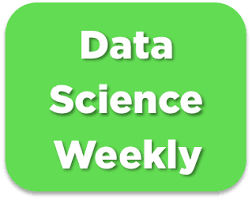

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Imports

In [1]:
!pip install plotly
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeClassifierCV, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
pio.renderers.default = "iframe_connected"

     |████████████████████████████████| 26.5 MB 10.0 MB/s eta 0:00:01
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


# EDA

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
# Univariate analysis
from plotly.subplots import make_subplots

# Distribution of each numeric variable
num_features = ['age', 'total_pages_visited']
fig1 = make_subplots(rows = len(num_features), cols = 1, subplot_titles = num_features)
for i in range(len(num_features)):
    fig1.add_trace(
        go.Histogram(
            x = data[num_features[i]], nbinsx = 10),
        row = i + 1,
        col = 1)
fig1.update_layout(
        title = go.layout.Title(text = "Distribution of quantitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig1.show()

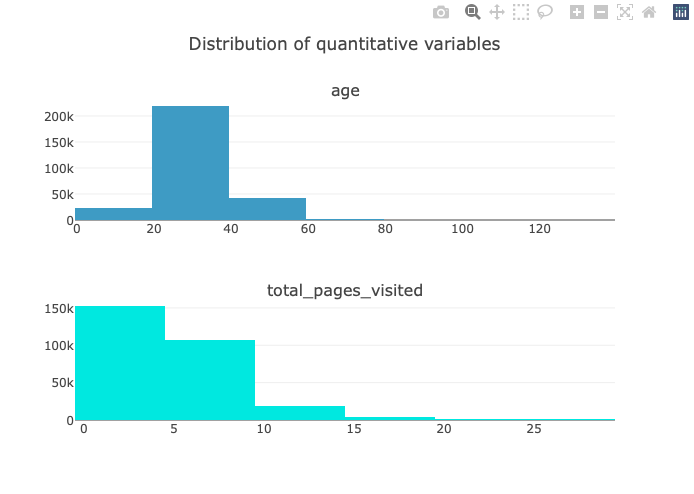

In [6]:
from IPython.display import display, Image
display(Image(filename='img/quantitative_variables_distribution.png'))

In [5]:
# Barplot of each qualitative variable
cat_features = ['country', 'new_user','source','converted']
fig2 = make_subplots(rows = len(cat_features), cols = 1, subplot_titles = cat_features)
for i in range(len(cat_features)):
    
    x_coords = data[cat_features[i]].value_counts().index.tolist()
    y_coords = data[cat_features[i]].value_counts().tolist()
    
    fig2.add_trace(
        go.Bar(
            x = x_coords,
            y = y_coords),
        row = i + 1,
        col = 1)
fig2.update_layout(
        title = go.layout.Title(text = "Barplot of qualitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig2.show()

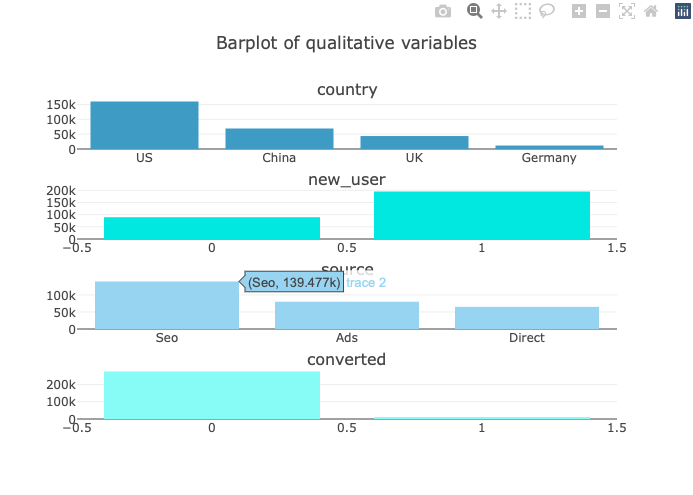

In [7]:
display(Image(filename='img/qualititative_variables_distribution.png'))

In [6]:
# Correlation matrix
corr_matrix = abs(round(data.corr(),2))

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist())


fig.show()

In [ ]:
display(Image(filename='img/correlation_matrix.png'))

In [7]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

# Model(s) design

In [8]:
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,4]
categorical_indices = [0,2,3]
target_variable = 'converted'

In [9]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [10]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [11]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['China' 23 0 'Direct' 2]
 ['China' 28 0 'Ads' 2]
 ['China' 30 1 'Seo' 7]
 ['UK' 37 1 'Seo' 3]
 ['US' 31 1 'Ads' 8]]
[['China' 24 1 'Ads' 14]
 ['US' 35 0 'Direct' 5]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [12]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Normalization & OneHotEncoder
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          0.          0.          0.          1.          0.
  -0.91458053 -0.85939501]
 [ 0.          0.          0.          0.          0.          0.
  -0.30994956 -0.85939501]
 [ 0.          0.          0.          1.          0.          1.
  -0.06809718  0.63639894]
 [ 0.          1.          0.          1.          0.          1.
   0.77838618 -0.56023622]
 [ 0.          0.          1.          1.          0.          0.
   0.05282902  0.93555773]]


In [13]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.transform(Y_test)

## a-Logistic regression

In [14]:
# Train model
print("Train model...")
classifier = LogisticRegression(warm_start = True)
classifier.fit(X_train, Y_train)
print("...Done.")


Train model...
...Done.


In [15]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [16]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [17]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7640283915896611
f1-score on test set :  0.7595396729254997


In [18]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246893    967]
 [  2557   5705]]

Confusion matrix on test set : 
[[27434   106]
 [  291   627]]



## b-Decision tree

In [19]:
# Perform grid search
print("Grid search...")
classifierDT = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [10, 12]
}
gridsearch = GridSearchCV(classifierDT, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best validation accuracy :  0.9853819664066344


In [20]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [21]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [22]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9861120872084397
accuracy on test set :  0.9854522454142948

f1-score on training set :  0.7605842363868884
f1-score on test set :  0.7496977025392986



## c-Random Forest

In [23]:
# Perform grid search
print("Grid search...")
classifierRF = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [10],
    'min_samples_leaf': [6],
    'min_samples_split': [3],
    'n_estimators': [12]
}
gridsearch = GridSearchCV(classifierRF, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 12}
Best validation accuracy :  0.9858661108306199


In [24]:
Y_train_pred = gridsearch.predict(X_train)

In [25]:
Y_test_pred = gridsearch.predict(X_test)

In [26]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9868500167888741
accuracy on test set :  0.985663082437276

f1-score on training set :  0.7746252676659529
f1-score on test set :  0.7539203860072375



## d-AdaBoost

In [27]:
from sklearn.ensemble import AdaBoostClassifier

In [28]:
regressor_ada = AdaBoostClassifier()
parameters = {'n_estimators':[200,300],
              "learning_rate":[1.0]}

regressor_ada_best = GridSearchCV(regressor_ada, parameters, cv = 3)
regressor_ada_best.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1.0], 'n_estimators': [200, 300]})

In [29]:
regressor_ada_best.best_params_

{'learning_rate': 1.0, 'n_estimators': 300}

In [30]:
Y_train_pred = regressor_ada_best.predict(X_train)

In [31]:
Y_test_pred = regressor_ada_best.predict(X_test)

In [32]:
ada_best_model = regressor_ada_best.best_estimator_
print("score Adaboost grid search train {}".format(ada_best_model.score(X_train, Y_train)))
print("\n")
print("score Adaboost grid search test {}".format(ada_best_model.score(X_test, Y_test)))

score Adaboost grid search train 0.9862018881626725


score Adaboost grid search test 0.9859441984679176


In [33]:
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.7628824476650563
f1-score on test set :  0.757869249394673


# predictions for the challenge with the best model (AdaBoost)
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [34]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

regressor_ada_best.fit(X,Y)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1.0], 'n_estimators': [200, 300]})

In [35]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country','age','new_user','source','total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [36]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")



# Normalization & OneHotEncoder


Encoding categorical features and standardizing numerical features...


In [37]:
X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

...Done
[[ 0.          1.          0.          0.          0.          1.
  -0.30994956  3.32882805]
 [ 0.          1.          0.          1.          1.          0.
  -1.03550673  0.03808136]
 [ 0.          0.          0.          1.          0.          1.
   0.17375521 -1.1585538 ]
 [ 0.          0.          1.          1.          0.          0.
   0.17375521  0.33724015]
 [ 0.          0.          0.          0.          0.          1.
  -0.67272814 -0.56023622]]


In [38]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': regressor_ada_best.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_valentin-lewandowski.csv', index=False)
